# Gaussian Process with Heteroscedastic likelihoods

### Loading necessary packages

In [1]:
using AugmentedGaussianProcesses
using Distributions
using LinearAlgebra
using Plots
default(lw=3.0, msw=0.0)

using CairoMakie

## Model generated data
The heteroscedastic noise mean that the variance of the likelihood
directly depends on the input.
To model this with Gaussian process, we define a GP `f` for the mean and another GP `g` for the variance
``y \sim f + \epsilon``
where ``\epsilon \sim \mathcal{N}(0, (\lambda \sigma(g))^{-1})``
We create a toy dataset with X ∈ [-10, 10] and sample `f`, `g` and `y` given this same generative model

In [2]:
N = 200
x = (sort(rand(N)) .- 0.5) * 20.0
x_test = range(-10, 10; length=500)
kernel = 5.0 * SqExponentialKernel() ∘ ScaleTransform(1.0) # Kernel function
K = kernelmatrix(kernel, x) + 1e-5I # The kernel matrix
f = rand(MvNormal(K)) # We draw a random sample from the GP prior

200-element Vector{Float64}:
  0.6690477276716676
  0.4800309133651116
  0.44381969073753025
  0.19437350804753045
  0.10003071490598786
  0.05202250467200597
 -0.04378294237052062
 -0.05998621143979836
 -0.07730524601973159
 -0.09003106696891365
  ⋮
  2.792521279977425
  2.8853855923431286
  3.07956064221223
  3.1745988466488075
  3.33329629458132
  3.539210304726584
  3.837728590129774
  3.975899918311507
  3.957026253263613

We add a prior mean on `g` so that the variance does not become too big

In [3]:
μ₀ = -3.0
g = rand(MvNormal(μ₀ * ones(N), K))
λ = 3.0 # The maximum possible precision
σ = inv.(sqrt.(λ * AGP.logistic.(g))) # We use the following transform to obtain the std. deviation
y = f + σ .* randn(N) # We finally sample the ouput

200-element Vector{Float64}:
  30.70560185070223
 -30.714073620865253
 -33.9910048994288
  -3.888475732207039
   6.3659153240169335
  -6.214959072682361
  -1.7272386154198307
   5.472902087338607
   2.7293020919747155
   0.44486869758369646
   ⋮
   2.9684245506636744
   2.130564069411568
   1.2781336214008276
   3.164918951641702
   5.314910711503469
   0.6942679970601757
   2.365211283533209
   4.622736897703849
   4.996882701571528

We can visualize the data:

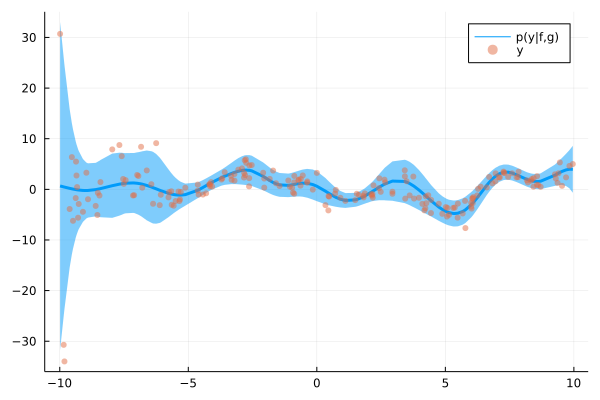

In [4]:
n_sig = 2 # Number of std. dev. around the mean
plot(x, f, ribbon = n_sig * σ, lab= "p(y|f,g)") # Mean and std. dev. of y
scatter!(x, y, alpha=0.5, msw=0.0, lab="y") # Observation samples

## Model creation and training
We will now use the augmented model to infer both `f` and `g`

In [5]:
model = VGP(
    x,
    y,
    deepcopy(kernel),
    HeteroscedasticLikelihood(λ),
    AnalyticVI();
    optimiser = true, # We optimise both the mean parameters and kernel hyperparameters
    mean = μ₀,
    verbose = 1
)

Variational Gaussian Process with a Gaussian likelihood with heteroscedastic noise infered by Analytic Variational Inference 

Model training, we train for around 100 iterations to wait for the convergence of the hyperparameters

In [6]:
train!(model, 100);

[ Info: Starting training Variational Gaussian Process with a Gaussian likelihood with heteroscedastic noise infered by Analytic Variational Inference  with 200 samples, 1 features and 2 latent GPs
[ Info: Training ended after 100 iterations. Total number of iterations 100


## Predictions
We can now look at the predictions and compare them with out original model

In [7]:
(f_m, g_m), (f_σ, g_σ) = predict_f(model, x_test; cov=true)
y_m, y_σ = proba_y(model, x_test)

([-2.0769140162177826, -2.0406448790347262, -2.003636653126162, -1.9659922899557165, -1.9278033447624277, -1.8891496447754637, -1.8500991358381327, -1.8107079023173924, -1.7710203528345931, -1.7310695622333376  …  0.8206436995707307, 0.7991746377198368, 0.7737362851851941, 0.7442882072843346, 0.7108265227929564, 0.6733843228966663, 0.6320317078814384, 0.5868754363426092, 0.538058186467353, 0.4857574337678514], [367.42685993832816, 326.10761874606845, 287.16830925159, 251.0728565053442, 218.11500468762299, 188.43351276169884, 162.03452316663487, 138.81781555884297, 118.6039893013964, 101.16022319805931  …  9.620901071153643, 10.455766769220812, 11.345046792046238, 12.287016587944006, 13.279228299255848, 14.318573218598225, 15.401371676564102, 16.5234834807451, 17.68042975217966, 18.867515539163023])

Let's first look at the differece between the latent `f` and `g`

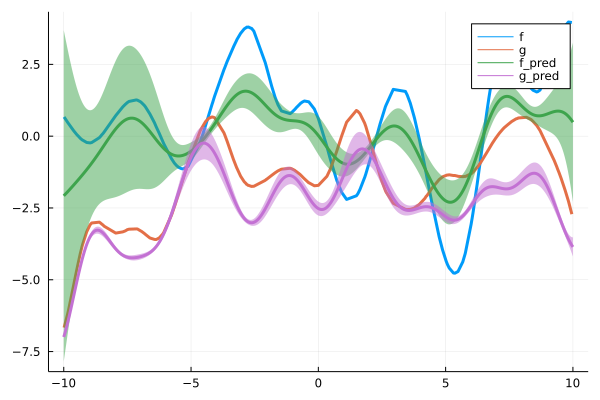

In [8]:
plot(x, [f, g]; label=["f" "g"])
plot!(x_test, [f_m, g_m]; ribbon=[n_sig * f_σ n_sig * g_σ], lab=["f_pred" "g_pred"], legend=true)

But it's more interesting to compare the predictive probability of `y` directly:

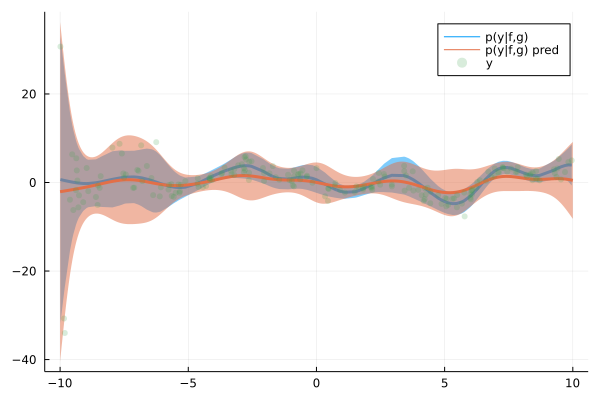

In [9]:
plot(x, f; ribbon = n_sig * σ, lab="p(y|f,g)")
plot!(x_test, y_m, ribbon = n_sig * sqrt.(y_σ), lab="p(y|f,g) pred")
scatter!(x, y; lab="y", alpha=0.2)

Or to explore the heteroscedasticity itself, we can look at the residuals

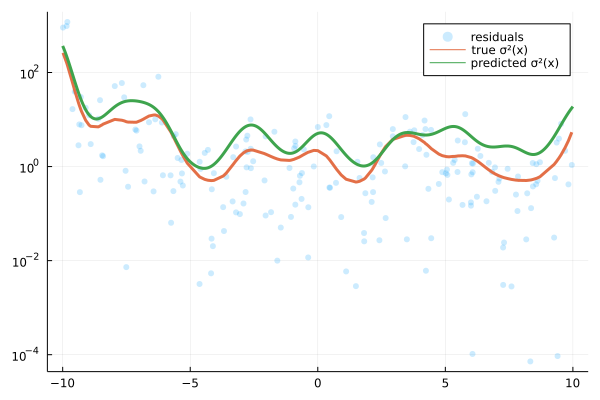

In [10]:
scatter(x, (f - y).^2; yaxis=:log, lab="residuals",alpha=0.2)
plot!(x, σ .^ 2; lab="true σ²(x)")
plot!(x_test, y_σ; lab="predicted σ²(x)")

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*